# Imports and setting up viz

NB : conda env1 on PC, lam1env on spirit (Python3.12)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import personnal tools
import sys
sys.path.append('../../python_tools/')
from tools import *
from tools_mapping import *

In [2]:
# rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m',edgecolor=(0, 0, 0, 0.3), facecolor='none')

# Load and edit files

LAM output analysis.

simu irr et simu no-irr.

## Area and period selection

In [3]:
# lon_min=-19
# lon_max=12
# lat_min=28
# lat_max=53

date_min = '2010-01-01'
date_max = '2022-12-31'

In [4]:
#filter to keep only certain period
# season='SON'
# sim = sim.where(sim['time.season'] == season, drop=True)
# simirr = simirr.where(simirr['time.season'] == season, drop=True)

## Sims

In [5]:
TS_flag=False

In [6]:
# noirr_dir='../../../JZ_simu_outputs/LAM/LAM_1000_40/noirr_2010_2022'
# irr_dir='../../../JZ_simu_outputs/LAM/LAM_1000_40/irr_2010_2022'
noirr_dir='../../../JZ_simu_outputs/LAM/LAM_1500_60/noirr'
irr_dir='../../../JZ_simu_outputs/LAM/LAM_1500_60/irr'

In [7]:
#sim
if TS_flag:
    filename = '{}/*/ATM/TS_MO/*.nc'.format(noirr_dir)
else:
    filename = '{}/*/ATM/MO/*.nc'.format(noirr_dir)


sim0 = xr.open_mfdataset(filename)
sim0.attrs['name'] = 'no_irr'
sim = sim0.rename({'time_counter':'time'})
sim.attrs["plot_color"] = 'red'
sim = sim.sel(lon=slice(lon_min, lon_max),lat=slice(lat_min, lat_max))

sim['evap'] = sim['evap'] *3600 * 24
sim['evap'].attrs['units'] = 'mm/d'
sim['evap'].attrs['long_name'] = 'Evapotranspiration'

sim['precip'] = sim['precip'] *3600 * 24
sim['precip'].attrs['units'] = 'mm/d'
sim['precip'].attrs['long_name'] = 'Total precipitation'

sim['fluxsens']= -sim['sens']

sim['netrad'] = sim['LWdnSFC'] - sim['LWupSFC'] + sim['SWdnSFC'] - sim['SWupSFC']
sim['netrad'].attrs['units'] = 'W/m2'

sim['SWnetSFC'] = sim['SWdnSFC'] - sim['SWupSFC']
sim['SWnetSFC'].attrs['units'] = 'W/m2'

sim['LWnetSFC'] = sim['LWdnSFC'] - sim['LWupSFC']
sim['LWnetSFC'].attrs['units'] = 'W/m2'

sim['P - E'] = sim['precip'] - sim['evap']
sim['P - E'].attrs['units'] = 'mm/d'

sim=compute_grid_cell_width(sim)

if not TS_flag :
    sim['Altitude'] = sim['phis'] / 9.81
    sim['Altitude'].attrs['units'] = 'm'

sim

<xarray.Dataset>
Dimensions:               (lat: 35, lon: 49, presnivs: 79, time: 156,
                           axis_nbounds: 2)
Coordinates:
  * lat                   (lat) float32 35.69 35.93 36.17 ... 43.38 43.62 43.87
  * lon                   (lon) float32 -9.899 -9.615 -9.33 ... 3.468 3.752
  * presnivs              (presnivs) float32 1.012e+05 1.009e+05 ... 5.297 1.483
    time_centered         (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 2010-01-16T12:00:00 ... 2022-...
    time_instant          (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: axis_nbounds
Data variables: (12/89)
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_instant_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    phis                  (time, lat, lon) float32 dask.array<chunksize=(1, 35, 49), meta=np.ndarray>
    aire                  (time, lat, lon) float32 dask.array<chunksize=(1, 35, 49), meta=np.ndarray>
    contfracATM           (time, lat, lon) float32 dask.array<chunksize=(1, 35, 49), meta=np.ndarray>
    ...                    ...
    LWnetSFC              (time, lat, lon) float32 dask.array<chunksize=(1, 35, 49), meta=np.ndarray>
    P - E                 (time, lat, lon) float32 dask.array<chunksize=(1, 35, 49), meta=np.ndarray>
    cell_width            (time, lat, lon) float32 2.571e+04 ... 2.283e+04
    cell_height           (time, lat, lon) float32 2.676e+04 ... 2.676e+04
    manual_area           (time, lat, lon) float32 6.881e+08 ... 6.108e+08
    Altitude              (time, lat, lon) float32 dask.array<chunksize=(1, 35, 49), meta=np.ndarray>
Attributes:
    name:         no_irr
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2024-Oct-24 17:17:56 GMT
    uuid:         15cc0aab-057e-451b-bf0c-046d80552902
    plot_color:   red

In [8]:
#sim irr
if TS_flag:
    filename = '{}/*/ATM/TS_MO/*.nc'.format(irr_dir)
else:
    filename = '{}/*/ATM/MO/*.nc'.format(irr_dir)

sim0irr = xr.open_mfdataset(filename)
sim0irr.attrs['name'] = 'irr'
simirr = sim0irr.rename({'time_counter':'time'})
simirr.attrs["plot_color"] = 'blue'
simirr = simirr.sel(lon=slice(lon_min, lon_max),lat=slice(lat_min, lat_max))

simirr['evap'] = simirr['evap'] *3600 * 24
simirr['evap'].attrs['units'] = 'mm/d'

simirr['precip'] = simirr['precip'] *3600 * 24
simirr['precip'].attrs['units'] = 'mm/d'

simirr['fluxsens']= -simirr['sens']

simirr['netrad'] = simirr['LWdnSFC'] - simirr['LWupSFC'] + simirr['SWdnSFC'] - simirr['SWupSFC']
simirr['netrad'].attrs['units'] = 'W/m2'

simirr['SWnetSFC'] = simirr['SWdnSFC'] - simirr['SWupSFC']
simirr['SWnetSFC'].attrs['units'] = 'W/m2'

simirr['LWnetSFC'] = simirr['LWdnSFC'] - simirr['LWupSFC']
simirr['LWnetSFC'].attrs['units'] = 'W/m2'

simirr['P - E'] = simirr['precip'] - simirr['evap']
simirr['P - E'].attrs['units'] = 'mm/d'

simirr=compute_grid_cell_width(simirr)

if not TS_flag:
    simirr['Altitude'] = simirr['phis'] / 9.81
    simirr['Altitude'].attrs['units'] = 'm'

simirr


<xarray.Dataset>
Dimensions:               (lat: 35, lon: 49, presnivs: 79, time: 156,
                           axis_nbounds: 2)
Coordinates:
  * lat                   (lat) float32 35.69 35.93 36.17 ... 43.38 43.62 43.87
  * lon                   (lon) float32 -9.899 -9.615 -9.33 ... 3.468 3.752
  * presnivs              (presnivs) float32 1.012e+05 1.009e+05 ... 5.297 1.483
    time_centered         (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 2010-01-16T12:00:00 ... 2022-...
    time_instant          (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: axis_nbounds
Data variables: (12/89)
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_instant_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    phis                  (time, lat, lon) float32 dask.array<chunksize=(1, 35, 49), meta=np.ndarray>
    aire                  (time, lat, lon) float32 dask.array<chunksize=(1, 35, 49), meta=np.ndarray>
    contfracATM           (time, lat, lon) float32 dask.array<chunksize=(1, 35, 49), meta=np.ndarray>
    ...                    ...
    LWnetSFC              (time, lat, lon) float32 dask.array<chunksize=(1, 35, 49), meta=np.ndarray>
    P - E                 (time, lat, lon) float32 dask.array<chunksize=(1, 35, 49), meta=np.ndarray>
    cell_width            (time, lat, lon) float32 2.571e+04 ... 2.283e+04
    cell_height           (time, lat, lon) float32 2.676e+04 ... 2.676e+04
    manual_area           (time, lat, lon) float32 6.881e+08 ... 6.108e+08
    Altitude              (time, lat, lon) float32 dask.array<chunksize=(1, 35, 49), meta=np.ndarray>
Attributes:
    name:         irr
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2024-Oct-24 17:20:19 GMT
    uuid:         9b14cf09-a875-4aee-8765-fef8fb231424
    plot_color:   blue

In [9]:
filename = '../../../JZ_simu_outputs/ZG_Frederique/*.nc'

zg = xr.open_mfdataset(filename)
zg.attrs['name'] = 'zg'
zg=zg.rename({'time_counter':'time'})
zg.attrs["plot_color"] = 'blue'

# zg = zg.sel(lon=slice(lon_min, lon_max),lat=slice(lat_max, lat_min))

zg['precip'] = zg['precip'] *3600 * 24
zg['precip'].attrs['units'] = 'mm/d'
zg['precip'].attrs['long_name'] = 'Total precipitation'

zg

zg_iLAM=zg.interp_like(sim)
ip_zg=zg_iLAM.where(ip_mask)

NameError: name 'ip_mask' is not defined

## Obs

### ERA5

In [10]:
#open ERA5 file
# filename = '../../../obs/ERA5/ERA5_eval_2010_2022.nc'
filename = '../../../obs/ERA5/ERA5_large_eval.nc'

era = xr.open_mfdataset(filename)
era.attrs['name'] = 'ERA5'
era.attrs["plot_color"] = 'black'
#define or edit vars
#name ERA5 vars like in LMDZOR outputs
dict =  {
        'longitude':'lon',
        'latitude':'lat',
        'e':'evap',
        'ro':'totrunoff',
        'tp':'precip',
        'u10':'u10m',
        'v10':'v10m',
        'p71.162' : 'uq',
        'p72.162' : 'vq',
        'sshf' : 'fluxsens',
        'slhf' : 'fluxlat',
        'si10' : 'sfcWind',
        'ssrd' : 'SWdnSFC',
        'strd' : 'LWdnSFC',
        'ssr' : 'SWnetSFC',
        'str' : 'LWnetSFC',
        }
era = era.rename(dict)
era=era.sel(time=slice(date_min, date_max))
era = era.sel(lon=slice(lon_min,lon_max),lat=slice(lat_max, lat_min))

#make evap positive in era
era['evap'] = -era['evap'] * 1000
era['evap'].attrs['units'] = 'mm/d'
era['precip'] = era['precip']*1000
era['precip'].attrs['units'] = 'mm/d'
era['fluxsens'] = -era['fluxsens'] / (3600 *24)
era['fluxsens'].attrs['units'] = 'W/m2'
# era['cldt'] = era['tcc']*100
# era['cldt'].attrs['units'] = '%'

era['P - E'] = era['precip'] - era['evap']
era['P - E'].attrs['units'] = 'mm/d'

era['calcWind'] = np.sqrt(era['u10m']**2 + era['v10m']**2)
era['calcWind'].attrs['units'] = 'm/s'
   
#convert 4 radiation variables from J/m2 to W/m2
era['SWdnSFC'] = era['SWdnSFC'] / (3600 *24)
era['SWdnSFC'].attrs['units'] = 'W/m2'
era['LWdnSFC'] = era['LWdnSFC'] / (3600 *24)
era['LWdnSFC'].attrs['units'] = 'W/m2'
era['SWnetSFC'] = era['SWnetSFC'] / (3600 *24)
era['SWnetSFC'].attrs['units'] = 'W/m2'
era['LWnetSFC'] = era['LWnetSFC'] / (3600 *24)
era['LWnetSFC'].attrs['units'] = 'W/m2'
#add up vars and netrad
era['LWupSFC'] = - era['LWnetSFC'] + era['LWdnSFC']
era['LWupSFC'].attrs['units'] = 'W/m2'
era['SWupSFC'] = - era['SWnetSFC'] + era['SWdnSFC']
era['SWupSFC'].attrs['units'] = 'W/m2'
era['netrad'] = era['LWnetSFC'] + era['SWnetSFC']
era['netrad'].attrs['units'] = 'W/m2'

era


<xarray.Dataset>
Dimensions:    (lon: 57, lat: 35, time: 156)
Coordinates:
  * lon        (lon) float32 -10.0 -9.75 -9.5 -9.25 -9.0 ... 3.25 3.5 3.75 4.0
  * lat        (lat) float32 44.0 43.75 43.5 43.25 ... 36.25 36.0 35.75 35.5
  * time       (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2022-12-01
Data variables: (12/25)
    u10m       (time, lat, lon) float32 dask.array<chunksize=(156, 35, 57), meta=np.ndarray>
    v10m       (time, lat, lon) float32 dask.array<chunksize=(156, 35, 57), meta=np.ndarray>
    t2m        (time, lat, lon) float32 dask.array<chunksize=(156, 35, 57), meta=np.ndarray>
    cp         (time, lat, lon) float32 dask.array<chunksize=(156, 35, 57), meta=np.ndarray>
    evap       (time, lat, lon) float32 dask.array<chunksize=(156, 35, 57), meta=np.ndarray>
    lsp        (time, lat, lon) float32 dask.array<chunksize=(156, 35, 57), meta=np.ndarray>
    ...         ...
    sfcWind    (time, lat, lon) float32 dask.array<chunksize=(156, 35, 57), meta=np.ndarray>
    P - E      (time, lat, lon) float32 dask.array<chunksize=(156, 35, 57), meta=np.ndarray>
    calcWind   (time, lat, lon) float32 dask.array<chunksize=(156, 35, 57), meta=np.ndarray>
    LWupSFC    (time, lat, lon) float64 dask.array<chunksize=(156, 35, 57), meta=np.ndarray>
    SWupSFC    (time, lat, lon) float64 dask.array<chunksize=(156, 35, 57), meta=np.ndarray>
    netrad     (time, lat, lon) float64 dask.array<chunksize=(156, 35, 57), meta=np.ndarray>
Attributes:
    Conventions:                CF-1.6
    history:                    Tue Sep 24 09:53:59 2024: ncks -A -v si10 ERA...
    history_of_appended_files:  Tue Sep 24 09:53:59 2024: Appended file ERA5_...
    NCO:                        netCDF Operators version 5.0.6 (Homepage = ht...
    name:                       ERA5
    plot_color:                 black

In [11]:
# #open tqruv file
# filename='../../../obs/TQRUV_850_2010_2022_monthly.nc'
# tqruv = xr.open_dataset(filename)
# tqruv.attrs['name'] = 'ERA5'
# tqruv = tqruv.sel(longitude=slice(-13,6),latitude=slice(49,32))
# #rename longitude and latitude to lon and lat
# tqruv = tqruv.rename({'longitude':'lon','latitude':'lat'})

# #rename all variables to add 850 in name
# tqruv['u850'] = tqruv['u']
# tqruv['v850'] = tqruv['v']
# tqruv['q850'] = tqruv['q']
# tqruv['t850'] = tqruv['t']
# tqruv['r850'] = tqruv['r']
# tqruv

### ERA-Land

In [12]:
filename = '../../../obs/ERALand/ERA5-Land.nc'
eraland = xr.open_dataset(filename)
eraland.attrs['name'] = 'ERA5-Land'
rename_dict = {'longitude':'lon',
               'latitude':'lat',
               'valid_time':'time',
               'skt':'temp_sol',
               'sro':'runoff',
               'ro':'mrro',
               'ssr':'SW_net',
               'str':'LW_net',
               'sshf':'fluxsens',
               'slhf':'fluxlat',
               'tp':'precip',
               'src':'fastr'
               }
eraland = eraland.rename(rename_dict)

eraland['mrsos'] = eraland['swvl1']*0.1*1000
eraland['mrsos'].attrs['units'] = 'mm'
#average variables swl1 to swvl4
eraland['lvl1-4_ave'] = (eraland['swvl1'] * 7 + eraland['swvl2'] * 21 + eraland['swvl3'] * 72 + eraland['swvl4'] * 189 )  / 289
eraland['humtot'] = eraland['lvl1-4_ave']*2*1000
eraland['humtot'].attrs['units'] = 'mm'

eraland['evap'] = - eraland['fluxlat'] * 0.408 * 0.0864
eraland['evap'].attrs['units'] = 'mm/d'

eraland

<xarray.Dataset>
Dimensions:     (time: 156, lat: 401, lon: 451)
Coordinates:
  * time        (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2022-12-01
  * lat         (lat) float64 60.0 59.9 59.8 59.7 59.6 ... 20.3 20.2 20.1 20.0
  * lon         (lon) float64 -25.0 -24.9 -24.8 -24.7 ... 19.7 19.8 19.9 20.0
Data variables: (12/21)
    number      int64 ...
    expver      (time) object ...
    temp_sol    (time, lat, lon) float32 ...
    fastr       (time, lat, lon) float32 ...
    swvl1       (time, lat, lon) float32 nan nan nan ... -7.641e-21 -7.641e-21
    swvl2       (time, lat, lon) float32 nan nan nan ... -1.809e-22 -1.809e-22
    ...          ...
    v10         (time, lat, lon) float32 ...
    precip      (time, lat, lon) float32 ...
    mrsos       (time, lat, lon) float32 nan nan nan ... -7.641e-19 -7.641e-19
    lvl1-4_ave  (time, lat, lon) float32 nan nan nan ... -2.031e-22 -2.031e-22
    humtot      (time, lat, lon) float32 nan nan nan ... -4.061e-19 -4.061e-19
    evap        (time, lat, lon) float32 nan nan nan nan ... 851.5 837.7 831.2
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-31T11:01 GRIB to CDM+CF via cfgrib-0.9.1...
    name:                    ERA5-Land

### GLEAM

In [13]:
#gleam
# filename='../../../obs/evap/E_1980-2022_GLEAM_v3.8a_MO.nc'
# gleam0=xr.open_dataset(filename)
# gleam0.attrs['name']='GLEAM'
# gleam = gleam0.sel(lon=slice(lon_min, lon_max),lat=slice(lat_max, lat_min))
# #adapt period
# gleam=gleam.sel(time=slice(date_min,date_max))
# #name gleam vars like in LMDZOR outputs
# dict =  {
#         'E':'evap'
#         }
# gleam = gleam.rename(dict)
# #convert mm/month to mm/day
# gleam['evap']=gleam['evap']/31
# gleam['evap'].attrs['units']='mm/d'
# gleam

filename = '../../../obs/GLEAMv4.1a/E/*'
gleam = xr.open_mfdataset(filename)
gleam.attrs['name'] = 'GLEAMv4.1a'
gleam.attrs['plot_color'] = 'black'
#restrict lon lat
gleam = gleam.sel(lon=slice(lon_min,lon_max),lat=slice(lat_max,lat_min))
#rename var SM
gleam['evap']=gleam['E'] / 31
gleam['evap'].attrs['units'] = 'mm/d'
gleam

<xarray.Dataset>
Dimensions:  (time: 156, lon: 140, lat: 85)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-31 2010-02-28 ... 2022-12-31
  * lon      (lon) float64 -9.95 -9.85 -9.75 -9.65 -9.55 ... 3.65 3.75 3.85 3.95
  * lat      (lat) float64 43.95 43.85 43.75 43.65 ... 35.85 35.75 35.65 35.55
Data variables:
    E        (time, lat, lon) float32 dask.array<chunksize=(12, 85, 140), meta=np.ndarray>
    evap     (time, lat, lon) float32 dask.array<chunksize=(12, 85, 140), meta=np.ndarray>
Attributes:
    name:        GLEAMv4.1a
    plot_color:  black

### FluxCom

In [14]:
filename='../../..//obs/FluxCom/ensemble_rs-_meteo_ALL/monthly/*.RS_METEO.EBC-*.MLM-ALL.METEO-ALL.720_360.monthly.*.nc'
fluxcom0=xr.open_mfdataset(filename)
fluxcom=fluxcom0.sel(lon=slice(-13,6.25),lat=slice(lat_max, lat_min))
fluxcom=fluxcom.sel(time=slice(date_min,date_max))

fluxcom.attrs["name"]='FluxCom'
fluxcom.attrs["plot_color"] = 'purple'

fluxcom['evap'] = fluxcom['LE'] * 0.408 # To convert from MJ/m2/d to mm/d
fluxcom['evap'].attrs['units'] = 'mm/d'

fluxcom['fluxlat'] = fluxcom['LE'] / 0.0864 # To convert from MJ/m2/d to W/m2
fluxcom['fluxlat'].attrs['units'] = 'W/m²'

fluxcom['fluxsens'] = fluxcom['H'] / 0.0864 # To convert from MJ/m2/d to W/m2
fluxcom['fluxsens'].attrs['units'] = 'W/m²'

fluxcom['netrad'] = fluxcom['Rn'] / 0.0864 # To convert from MJ/m2/d to W/m2
fluxcom['netrad'].attrs['units'] = 'W/m²'
fluxcom

<xarray.Dataset>
Dimensions:    (time: 48, lat: 17, lon: 39, nbnds: 2)
Coordinates:
  * lon        (lon) float64 -12.75 -12.25 -11.75 -11.25 ... 4.75 5.25 5.75 6.25
  * lat        (lat) float64 43.75 43.25 42.75 42.25 ... 37.25 36.75 36.25 35.75
  * time       (time) datetime64[ns] 2010-01-16 2010-02-16 ... 2013-12-16
Dimensions without coordinates: nbnds
Data variables: (12/16)
    H          (time, lat, lon) float32 dask.array<chunksize=(12, 17, 39), meta=np.ndarray>
    H_mad      (time, lat, lon) float32 dask.array<chunksize=(12, 17, 39), meta=np.ndarray>
    H_n        (time, lat, lon) float32 dask.array<chunksize=(12, 17, 39), meta=np.ndarray>
    lat_bnds   (time, lat, nbnds) float64 dask.array<chunksize=(12, 17, 2), meta=np.ndarray>
    lon_bnds   (time, lon, nbnds) float64 dask.array<chunksize=(12, 39, 2), meta=np.ndarray>
    time_bnds  (time, nbnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    ...         ...
    Rn_mad     (time, lat, lon) float32 dask.array<chunksize=(12, 17, 39), meta=np.ndarray>
    Rn_n       (time, lat, lon) float32 dask.array<chunksize=(12, 17, 39), meta=np.ndarray>
    evap       (time, lat, lon) float32 dask.array<chunksize=(12, 17, 39), meta=np.ndarray>
    fluxlat    (time, lat, lon) float32 dask.array<chunksize=(12, 17, 39), meta=np.ndarray>
    fluxsens   (time, lat, lon) float32 dask.array<chunksize=(12, 17, 39), meta=np.ndarray>
    netrad     (time, lat, lon) float32 dask.array<chunksize=(12, 17, 39), meta=np.ndarray>
Attributes: (12/17)
    Comment:                        Ensemble median of 36 members
    Energy_Balance_Correction_EBC:  NONE, BWR, RES
    Machine_Learning_Method_MLM:    RF, ANN, MARS
    Meteorolgical_Data_METEO:       CRUNCEP_v8, WFDEI, CERES_GPCP, GSWP3
    Version:                        v1
    SETUP:                          RS_METEO
    ...                             ...
    Provided_By:                    Martin Jung [mjung@bgc-jena.mpg.de] on be...
    Created_By:                     Fabian Gans [fgans@bgc-jena.mpg.de], Ulri...
    Temporal_Aggregation_Method:    first interpolate to daily,  second aggre...
    History:                        created: Mon Mar 18 15:20:10 2019
    name:                           FluxCom
    plot_color:                     purple

### GPCC

In [15]:
#gpcc
filename='../../../obs/precips/precip.mon.total.0.25x0.25.v2020.nc'
gpcc0=xr.open_mfdataset(filename)
gpcc0.attrs['name'] = 'GPCC'
gpcc=gpcc0.sel(time=slice(date_min,date_max))
gpcc['lon'] = ((gpcc['lon'] + 180) % 360) - 180
gpcc1 = gpcc.sortby('lon')

# gpcc=gpcc.sel(lon=slice(-13,6.25),lat=slice(lat_min, lat_max))
gpcc=gpcc1.sel(lon=slice(-13,6.25),lat=slice(lat_max, lat_min))

gpcc.attrs["plot_color"] = 'black'

# gpcc1=gpcc.sel(lon=slice(347,360),lat=slice(lat_max, lat_min))
# gpcc2=gpcc.sel(lon=slice(0,6.25),lat=slice(lat_max, lat_min))
# gpcc=xr.combine_by_coords([gpcc1, gpcc2])
# gpcc = gpcc.where(gpcc['lon'] < 6.25, drop=True)

# gpcc['lon']=gpcc['lon']-180.0
# gpcc=gpcc.sel(lon=slice(-13,6.25))

gpcc['precip'] = gpcc['precip'] / 30 #convert to mm/d
gpcc['precip'].attrs['units'] = 'mm/d'
gpcc

<xarray.Dataset>
Dimensions:  (lat: 34, lon: 77, time: 120)
Coordinates:
  * lat      (lat) float32 43.88 43.62 43.38 43.12 ... 36.38 36.12 35.88 35.62
  * lon      (lon) float32 -12.88 -12.62 -12.38 -12.12 ... 5.625 5.875 6.125
  * time     (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2019-12-01
Data variables:
    precip   (time, lat, lon) float32 dask.array<chunksize=(120, 34, 77), meta=np.ndarray>
Attributes:
    Original_Source:  http://www.dwd.de/en/FundE/Klima/KLIS/int/GPCC/GPCC.htm...
    Reference:        Users of the data sets are kindly requested to give fee...
    original_source:  ftp://ftp-anon.dwd.de/pub/data/gpcc/html/fulldata_downl...
    Conventions:      CF 1.0
    dataset_title:    Global Precipitation Climatology Centre (GPCC)
    title:            GPCC Full Data Reanalysis Version 2020 0.25x0.25 Monthl...
    history:          Created 07/2021  based on V2020 data obtained via wget
    References:       https://www.psl.noaa.gov/data/gridded/data.gpcc.html
    name:             GPCC
    plot_color:       black

### CRU

In [16]:
filename = '../../../obs/CRU_temp/extracted/cru_*.tmp.dat.nc'
cru = xr.open_mfdataset(filename)
cru = cru.sel(time=slice(date_min,date_max))
cru=cru.sel(lon=slice(lon_min, lon_max),lat=slice(lat_min, lat_max))
cru.attrs['name'] = 'CRU'
cru.attrs['plot_color'] = 'black'

cru['t2m'] = cru['tmp'] + 273.15
cru['t2m'].attrs['units'] = 'K'
cru['t2m'].attrs['long_name'] = '2m temperature'

cru

<xarray.Dataset>
Dimensions:  (lon: 28, lat: 17, time: 156)
Coordinates:
  * lon      (lon) float32 -9.75 -9.25 -8.75 -8.25 -7.75 ... 2.25 2.75 3.25 3.75
  * lat      (lat) float32 35.75 36.25 36.75 37.25 ... 42.25 42.75 43.25 43.75
  * time     (time) datetime64[ns] 2010-01-16 2010-02-15 ... 2022-12-16
Data variables:
    tmp      (time, lat, lon) float32 dask.array<chunksize=(12, 17, 28), meta=np.ndarray>
    stn      (time, lat, lon) float64 dask.array<chunksize=(12, 17, 28), meta=np.ndarray>
    mae      (time, lat, lon) float32 dask.array<chunksize=(12, 17, 28), meta=np.ndarray>
    maea     (time, lat, lon) float32 dask.array<chunksize=(12, 17, 28), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(12, 17, 28), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.4
    title:        CRU TS4.08 Mean Temperature
    institution:  Data held at British Atmospheric Data Centre, RAL, UK.
    source:       Run ID = 2406270035. Data generated from:tmp.2406262226.dtb
    history:      Thu 27 Jun 01:31:07 BST 2024 : User f098 : Program makegrid...
    references:   Information on the data is available at http://badc.nerc.ac...
    comment:      Access to these data is available to any registered CEDA user.
    contact:      support@ceda.ac.uk
    name:         CRU
    plot_color:   black

## Masking, interpolation, and time period selection

### Sims and products interp to products

In [17]:
# sim_iera = sim.interp_like(era)
# sim_igpcc = sim.interp_like(gpcc)
# sim_igleam = sim.interp_like(gleam)
# sim_ifluxcom = sim.interp_like(fluxcom)
# # sim_itqruv = sim.interp_like(tqruv)

# simirr_iera = simirr.interp_like(era)
# simirr_igpcc = simirr.interp_like(gpcc)
# simirr_igleam = simirr.interp_like(gleam)
# simirr_ifluxcom = simirr.interp_like(fluxcom)
# # simirr_itqruv = simirr.interp_like(tqruv)

In [18]:
# #same masks but adatped when interpolated on obs grid
# con_mask_iera=sim_iera['contfracOR']>0.9
# ip_mask_iera=polygon_to_mask(sim_iera, iberian_peninsula)

# con_mask_igpcc=sim_igpcc['contfracOR']>0.9
# ip_mask_igpcc=polygon_to_mask(sim_igpcc, iberian_peninsula)

# con_mask_igleam=sim_igleam['contfracOR']>0.9
# ip_mask_igleam=polygon_to_mask(sim_igleam, iberian_peninsula)

# con_mask_ifluxcom=sim_ifluxcom['contfracOR']>0.9
# ip_mask_ifluxcom=polygon_to_mask(sim_ifluxcom, iberian_peninsula)

In [19]:
# ip_sim_iera = ip_sim.interp_like(era)
# ip_sim_igpcc = ip_sim.interp_like(gpcc)
# ip_sim_igleam = ip_sim.interp_like(gleam)
# ip_sim_ifluxcom = ip_sim.interp_like(fluxcom)
# ip_sim_itqruv = ip_sim.interp_like(tqruv)

# ip_simirr_iera = ip_simirr.interp_like(era)
# ip_simirr_igpcc = ip_simirr.interp_like(gpcc)
# ip_simirr_igleam = ip_simirr.interp_like(gleam)
# ip_simirr_ifluxcom = ip_simirr.interp_like(fluxcom)
# ip_simirr_itqruv = ip_simirr.interp_like(tqruv)

In [20]:
# sim_iipera = sim.interp_like(era).where(con_mask_iera).where(ip_mask_iera['mask'], drop=False)
# sim_iipgpcc = sim.interp_like(ip_gpcc).where(con_mask_igpcc).where(ip_mask_igpcc['mask'], drop=False)
# sim_iipgleam = sim.interp_like(ip_gleam).where(con_mask_igleam).where(ip_mask_igleam['mask'], drop=False)
# sim_iipfluxcom = sim.interp_like(ip_fluxcom).where(con_mask_ifluxcom).where(ip_mask_ifluxcom['mask'], drop=False)

# simirr_iipera = simirr.interp_like(era).where(con_mask_iera).where(ip_mask_iera['mask'], drop=False)
# simirr_iipgpcc = simirr.interp_like(ip_gpcc).where(con_mask_igpcc).where(ip_mask_igpcc['mask'], drop=False)
# simirr_iipgleam = simirr.interp_like(ip_gleam).where(con_mask_igleam).where(ip_mask_igleam['mask'], drop=False)
# simirr_iipfluxcom = simirr.interp_like(ip_fluxcom).where(con_mask_ifluxcom).where(ip_mask_ifluxcom['mask'], drop=False)

### Products interp to sim

In [21]:
#continental fraction mask (LMDZ outputs)
con_mask=sim.mean(dim='time')['contfracOR']>0.95
ip_mask=polygon_to_mask(sim, iberian_peninsula) * con_mask

In [22]:
# cont_sim=sim.where(con_mask)
# cont_simirr=simirr.where(con_mask)

ip_sim = sim.where(ip_mask, drop=False)
ip_simirr = simirr.where(ip_mask, drop=False)
# ip_sim.attrs['plot_color']='red'
# ip_simirr.attrs['plot_color']='blue'

In [23]:
# era5
# cont_era=era.where(con_mask_iera)
# ip_era = cont_era.where(ip_mask_iera['mask'], drop=False)

era_isim=era.interp_like(sim)
# cont_era_isim=era_isim.where(con_mask)
ip_era_isim = era_isim.where(ip_mask, drop=False)
# era_isim.attrs['plot_color']=era.attrs['plot_color']
# ip_era_isim.attrs['plot_color']=era.attrs['plot_color']

In [24]:
#era-land
# cont_eraland=eraland.where(con_mask)
# ip_eraland = eraland.where(ip_mask, drop=False)

eraland_isim=eraland.interp_like(sim)
# cont_eraland_isim=eraland_isim.where(con_mask)
ip_eraland_isim = eraland_isim.where(ip_mask, drop=False)

In [25]:
#gleam
# cont_gleam=gleam.where(con_mask_igleam)
# ip_gleam = cont_gleam.where(ip_mask_igleam['mask'], drop=False)

gleam_isim=gleam.interp_like(sim)
cont_gleam_isim=gleam_isim.where(con_mask)
ip_gleam_isim = cont_gleam_isim.where(ip_mask, drop=False)

# gleam_iipera=gleam.interp_like(era).where(con_mask_iera).where(ip_mask_iera['mask'], drop=False)

In [26]:
#fluxcom
# cont_fluxcom=fluxcom.where(con_mask_ifluxcom)
# ip_fluxcom = cont_fluxcom.where(ip_mask_ifluxcom['mask'], drop=False)

fluxcom_isim=fluxcom.interp_like(sim)
cont_fluxcom_isim=fluxcom_isim.where(con_mask)
ip_fluxcom_isim = cont_fluxcom_isim.where(ip_mask, drop=False)

# fluxcom_iipera=fluxcom.interp_like(era).where(con_mask_iera).where(ip_mask_iera['mask'], drop=False)

In [27]:
#gpcc
# cont_gpcc=gpcc.where(con_mask_igpcc)
# ip_gpcc = cont_gpcc.where(ip_mask_igpcc['mask'], drop=False)

gpcc_isim=gpcc.interp_like(sim)
cont_gpcc_isim=gpcc_isim.where(con_mask)
ip_gpcc_isim = cont_gpcc_isim.where(ip_mask, drop=False)

# gpcc_iipera=gpcc.interp_like(era).where(con_mask_iera).where(ip_mask_iera['mask'], drop=False)

In [28]:
#cru
# cont_cru=cru.where(con_mask)
# ip_cru = cont_cru.where(ip_mask, drop=False)

cru_isim=cru.interp_like(sim)
cont_cru_isim=cru_isim.where(con_mask)
ip_cru_isim = cont_cru_isim.where(ip_mask, drop=False)

## Diff datasets

In [29]:
compute_diffs=False

In [30]:
if compute_diffs:
    sim_diff=simirr-sim
    ip_sim_diff=ip_simirr-ip_sim

In [31]:
#era
if compute_diffs:
    sim_era_diff=sim - era_isim
    ip_sim_era_diff=ip_simirr - ip_era_isim
    #mean of both diff datasets
    sim_era_diff_mean = sim_era_diff.mean(dim='time')
    ip_sim_era_diff_mean = ip_sim_era_diff.mean(dim='time')

In [32]:
#gleam
if compute_diffs:
    sim_gleam_diff=sim - gleam_isim
    ip_sim_gleam_diff=ip_simirr - ip_gleam_isim
    #mean of both diff datasets
    sim_gleam_diff_mean = sim_gleam_diff.mean(dim='time')
    ip_sim_gleam_diff_mean = ip_sim_gleam_diff.mean(dim='time')

In [33]:
#gpcc
if compute_diffs:
    sim_gpcc_diff=sim - gpcc_isim
    ip_sim_gpcc_diff=ip_simirr - ip_gpcc_isim
    #mean of both diff datasets
    sim_gpcc_diff_mean = sim_gpcc_diff.mean(dim='time')
    ip_sim_gpcc_diff_mean = ip_sim_gpcc_diff.mean(dim='time')

# Maps

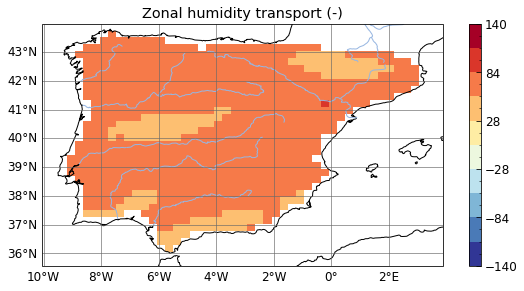

In [34]:
#Display map of var for ds
var='uq'
ds=ip_sim
color_map=emb

vmin=-140
vmax= 140
# vmin=None
# vmin,vmax=None, None
# cbar_label='Altitude (m)'
cbar_label=None
title=None
poly=None

# map_plotvar(ds[var])
map_ave(ds, var, cmap=color_map, figsize=(8,4), title=title, vmin=vmin, vmax=vmax, clabel=cbar_label, poly=poly)

In [35]:
#Diff map
var='precip'
ds1=ip_zg
# ds2=ip_era_isim
# ds2=ip_fluxcom_isim
# ds2=gleam_isim
ds2=ip_gpcc_isim

max_value= 2.0
min_value=-2.0
# max_value=None
# min_value=None
# min_value,max_value=None, None
cmap=emb_neutral
clabel='Precipitation bias (mm/d)'
title='Bias : LMDZ ZG - GPCC (2010-2014)'

map_diff_ave(ds1, ds2, var, vmin=min_value, vmax=max_value, cmap=cmap,clabel=clabel, title=title,
             sig=False, sig_viz=3)
# diff=ds1[var]-ds2[var]
# map_seasons(diff, cmap=emb_neutral, vmin=min_value, vmax=max_value, title=title, hex=False

NameError: name 'ip_zg' is not defined

In [ ]:
#map for 4 seasons
var='t2m'
ds1=ip_simirr
ds2=ip_sim
max_value= 0.5
min_value=-0.5
# min_value,max_value=None, None
cmap=emb

diff=ds1[var]-ds2[var]
title='{} diff, {} vs {} ({})'.format( var, ds1.attrs['name'], ds2.attrs['name'], ds1[var].attrs['units'])
plotvar=diff

map_seasons(plotvar, cmap=cmap, vmin=min_value, vmax=max_value, title=title, hex=False)

In [ ]:
# Display 2 maps of var
var = 'SWupSFC'
min_value=None
max_value=None
color_map=wet
ds1=sim_iera
ds2=era
map_two_ds(ds1, ds2, var, vmin=min_value, figsize=(15,6), vmax=max_value, cmap=color_map)

In [ ]:
#Display map of var for ds on restricted area
var='evap'
ds = sim
latmin=36.7
latmax=36.9
lonmin=-6.4
lonmax=-6.2

#restrict ds to latmin, latmax, lonmin, lonmax
ds = ds.where(ds.lat >= latmin, drop=True).where(ds.lat <= latmax, drop=True)
ds = ds.where(ds.lon >= lonmin, drop=True).where(ds.lon <= lonmax, drop=True)
plotvar = ds[var].mean(dim='time')
map_plotvar(plotvar, cmap=emb_neutral_neutral, vmax=None, title=var)

In [ ]:
#Relative diff map
var='precip'
max_value=None
ds1=cont_fluxcom
ds2=ip_fluxcom
# plt.title('Gross primary production relative difference (%)')
map_rel_diff_ave(ds1, ds2, var, vmax=max_value)

In [ ]:
ds=sim
scale=2000
dist=2
extra_var='norm'
cmap=emb
vmin=None
vmax=1550
vmin,vmax=None, None
poly=ebro
map_moisture_transport(ds, extra_var=extra_var, cmap=cmap, vmin=vmin, vmax=vmax, dist=dist,scale=scale, poly=poly)

# Time series

In [81]:
ip_gpcc_isim.attrs['plot_color']='black'

In [38]:
var='precip'

ds1=ip_gpcc_isim
ds2=ip_sim
ds3=ip_simirr
# ds4=ip_gleam_isim
# ds5=ip_fluxcom_isim

# ds5=ip_eraland_isim
# ds4=ip_gpcc_isim
# ds1=ip_cru_isim

ds_list=[ds1, ds2, ds3]#, ds4]#, ds5]

# ds1=fluxcom
# ds_list=[ds1]

year_min=2010
year_max=2019

ylabel='Precipitation (mm/d)'
# title='Seasonal cycle of {} ({}, {}-{})'.format(var, ds1[var].attrs['units'], year_min, year_max)
title='off'
figsize=(8.5,5)

# time_series_ave(ds_list, var, ds_colors=True, year_min=year_min, year_max=year_max, title='{} {}'.format(var, ds1[var].attrs['units']))
seasonal_cycle_ave(ds_list, var, ds_colors=True, year_min=year_min, year_max=year_max, ylabel=ylabel, title=title, figsize=figsize)

: 

# Scatter plots

In [ ]:
var1='precip'
ds1=ip_sim_era_diff_mean
#remove values where precip is smaller than 5
mask=ds1[var1] < 2
ds1=ds1.where(mask)

var2='evap'
# ds2=ip_sim_era_diff
ds2=ds1

scatter_vars(ds1, ds2, var1, var2, reg=False)

In [ ]:
var1='precip'
ds1=ip_sim_gpcc_diff_mean
#remove values where precip is smaller than 2
mask=ds1[var1] < 2
ds1=ds1.where(mask)

var2='evap'
ds2=ip_sim_gleam_diff_mean
ds2=ds2.where(mask)
scatter_vars(ds1, ds2, var1, var2, reg=False)

# Wind

In [ ]:
ds = ip_sim
dist=2
height='10m'
scale=20
vmin=0
vmax=2
map_wind(ds, dist=dist, height=height, vmin=vmin, vmax=vmax, scale=scale)

In [ ]:
ds1 = ip_simirr
# ds1=ds1.sel(time=ds1['time.month'].isin([6,7,8]))
ds2 = ip_sim
# ds2=ds2.sel(time=ds2['time.month'].isin([6,7,8]))
dist=5
height='10m'
scale=0.2
vmin=-0.1
vmax= 0.1
map_wind_diff(ds1, ds2, dist=dist, height=height, vmin=vmin, vmax=vmax, scale=scale)

In [ ]:
# 850hPa wind difference
ds1 = ip_simirr
ds2 = ip_sim
dist=2

#compute wind speed
wind_speed1 = (ds1['u850'][0,:,:]**2 + ds1['v850'][0,:,:]**2)**(1/2)
wind_speed2 = (ds2['u850'][0,:,:]**2 + ds2['v850'][0,:,:]**2)**(1/2)
wind_speed_diff = wind_speed1 - wind_speed2
#extract x and y (u and v) components and reduce dimension
longi=ds['lon'][::dist]
lati=ds['lat'][::dist]
windx1 = ds1['u850'][0,::dist,::dist]
windy1 = ds1['v850'][0,::dist,::dist]
windx2 = ds2['u850'][0,::dist,::dist]
windy2 = ds2['v850'][0,::dist,::dist]
windx_diff = windx1 - windx2
windy_diff = windy1 - windy2


#display map
fig = plt.figure(figsize=(10, 7.5))
ax = plt.axes(projection=ccrs.PlateCarree())
# gridline setup
ax.coastlines()
ax.add_feature(rivers)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.8)
gl.right_labels = False
gl.top_labels = False
gl.xlocator = plt.MaxNLocator(9)
gl.ylocator = plt.MaxNLocator(9)
wind_speed_diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=emb)
ax.quiver(longi, lati, windx_diff, windy_diff, transform=ccrs.PlateCarree(), scale=0.1)
plt.title('850hPa wind speed (m/s) and direction difference')
plt.show()


# Moisture fluxes

In [49]:
ebro_mask=polygon_to_mask(sim, ebro)

In [ ]:
ds=era
mask=ip_mask
mask=polygon_to_mask(ds, iberian_peninsula)
era_budget=moisture_budget(ds, mask)
era_budget

In [ ]:
ds=era_isim
mask=ip_mask
mask=polygon_to_mask(ds, iberian_peninsula)
era_budget=moisture_budget(ds, mask)
era_budget

# Vertical profiles

In [ ]:
filename='../../../JZ_simu_outputs/LAM/HF_outputs_LAM_concat/TS_MO_irr_*.nc'
lvls_irr=xr.open_mfdataset(filename)
lvls_irr.attrs["name"]='irr'
#rename time_counter to time
lvls_irr = lvls_irr.rename({'time_counter':'time'})
lvls_irr

In [ ]:
filename='../../../JZ_simu_outputs/LAM/HF_outputs_LAM_concat/TS_MO_noirr_*.nc'
lvls_noirr=xr.open_mfdataset(filename)
lvls_noirr.attrs["name"]='no_irr'
#rename time_counter to time
lvls_noirr = lvls_noirr.rename({'time_counter':'time'})
lvls_noirr

In [ ]:
filename = '{}/SRF/MO/*history.nc'.format(irr_dir)
orc0 = xr.open_mfdataset(filename)
orc = orc0.rename({'time_counter':'time'})


In [ ]:
orc_interp=orc.interp_like(lvls_irr)
irr_mask = (orc_interp['irrigmap_dyn']/orc_interp['Areas'])>0.1
nonirr_mask = (orc_interp['irrigmap_dyn']/orc_interp['Areas'])<=0.1

In [ ]:
lvls_irr_irrigated=lvls_irr.where(irr_mask)
lvls_irr_irrigated.attrs['name']='irrigated'
lvls_irr_nonirrigated=lvls_noirr.where(nonirr_mask)
lvls_irr_nonirrigated.attrs['name']='non_irrigated'

In [ ]:
ip_mask=polygon_to_mask(lvls_irr, iberic_peninsula)

ip_lvls_irr=lvls_irr.where(ip_mask, drop=False)
ip_lvls_irr.attrs['name']='irr'

ip_lvls_noirr=lvls_noirr.where(ip_mask, drop=False)
ip_lvls_noirr.attrs['name']='no_irr'

ip_lvls_irr_irrigated = lvls_irr.where(irr_mask).where(ip_mask, drop=False)
ip_lvls_irr_irrigated.attrs['name']='irrigated'

ip_lvls_irr_nonirrigated = lvls_irr.where(nonirr_mask).where(ip_mask, drop=False)
ip_lvls_irr_nonirrigated.attrs['name']='nonirrigated'

In [ ]:
# t and q profiles
#select a lon-lat box
latmin=41
latmax=43
lonmin=-2
lonmax=1
var='q'
ds1=simirr.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax))
ds2=sim.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax))

ds_list=[ds1, ds2]

profile_reflevs(ds_list, var)

In [ ]:
# profile
preslevelmax=50
var='ovap'
# select a lon-lat box
latmin=41
latmax=43
lonmin=-2
lonmax=1
# #spain
# latmin=36
# latmax=44
# lonmin=-9.5
# lonmax=3

ds1=ip_lvls_irr_irrigated
ds1= ds1.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax))
#select only JJA season
# ds1=ds1.sel(time=ds1['time.month'].isin([6,7,8]))

ds2=ip_lvls_irr_nonirrigated
ds2=ds2.sel(lon=slice(lonmin,lonmax),lat=slice(latmin,latmax))
#select only JJA season
# ds2=ds2.sel(time=ds2['time.month'].isin([6,7,8]))

ds_list=[ds1, ds2]
profile_preslevs(ds_list, var, preslevelmax=preslevelmax)

In [ ]:
#temp at first level (better than t2m)
months=[6,7,8]
var1=ip_lvls_noirr['ovap'][:,0,:,:].sel(time=simirr['time.month'].isin(months))
var2=ip_lvls_irr['ovap'][:,0,:,:].sel(time=simirr['time.month'].isin(months))
temp_diff=(var2-var1).mean(dim='time')
temp_diff.attrs['units']='K'
# p_values = xr.apply_ufunc(
#     lambda x, y: ttest_ind(x, y, axis=0, nan_policy='omit').pvalue, 
#     var1, var2,
#     input_core_dims=[['time'], ['time']],
#     output_core_dims=[[]],
#     vectorize=True,
#     dask='parallelized',
#     output_dtypes=[float]
# )
# mask=p_values<0.05
# temp_diff=temp_diff.where(mask)
map_plotvar(temp_diff, in_cmap=emb, in_vmax=None, title='First level temperature (K) diff (irr-noirr)')

# Testing seasonnal dataset

In [ ]:
ds=ip_simirr
var='evap'
ds_seasons=seasonnal_ds_list(ds)
# time_series_ave(ds_seasons, var)
for ds_season in ds_seasons:
    map_ave(ds_season, var, cmap=wet, vmin=0, vmax=5, title='{} ({})'.format(var, ds_season.attrs['name']))